<a href="https://colab.research.google.com/github/anruki/Deep-Learning-P2/blob/main/PW2_embedddings_V3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%load_ext tensorboard

In [1]:
import numpy as np
import tensorflow as tf
import re
import pandas as pd
import spacy
import gc
from itertools import combinations
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix, vstack as sparse_vstack
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import Model, Input, layers
from tensorflow.keras.layers import Embedding, Dot, Reshape, Dense,Bidirectional, LSTM, GRU
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import skipgrams, pad_sequences
from keras.callbacks import TensorBoard

# **FASE 1**

In [2]:
# Step 1: Load data
train_df = pd.read_csv('train.csv', encoding='latin1')
test_df = pd.read_csv('test.csv', encoding='latin1')

def limpiar_texto(texto):
    texto = re.sub(r'[^\w\s]', '', str(texto)).lower()
    return texto

Por ejemplo, las 3 primeras entradas de `train_df`:

In [ ]:
train_df.head(3)

,textID,text,selected_text,sentiment,Time of Tweet,Age of User,Country,Population -2020,Land Area (Km²),Density (P/Km²)
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,morning,0-20,Afghanistan,38928346,652860.0,60
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,noon,21-30,Albania,2877797,27400.0,105
2,088c60f138,my boss is bullying me...,bullying me,negative,night,31-45,Algeria,43851044,2381740.0,18


Recuento de NaNs:

In [3]:
# Contar NaNs por columna en train_df
print("NaNs en train_df:")
print(train_df.isna().sum())

# Contar NaNs por columna en test_df
print("\nNaNs en test_df:")
print(test_df.isna().sum())

NaNs en train_df:
textID              0
text                1
selected_text       1
sentiment           0
Time of Tweet       0
Age of User         0
Country             0
Population -2020    0
Land Area (Km²)     0
Density (P/Km²)     0
dtype: int64

NaNs en test_df:
textID              1281
text                1281
sentiment           1281
Time of Tweet       1281
Age of User         1281
Country             1281
Population -2020    1281
Land Area (Km²)     1281
Density (P/Km²)     1281
dtype: int64


In [4]:
# Eliminar filas con NaN en la columna 'text' en test_df
test_df = test_df.dropna(subset=['text'])
train_df = train_df.dropna(subset=['text'])

In [5]:
# 1) Carga y limpieza
train_df['text_clean'] = train_df['text'].apply(limpiar_texto)
test_df ['text_clean'] = test_df ['text'].apply(limpiar_texto)


train_corpus = train_df['text_clean'].tolist()
test_corpus  = test_df ['text_clean'].tolist()
corpus       = train_corpus + test_corpus

print(f"Frases usadas → train: {len(train_corpus)}, test: {len(test_corpus)}")

# 3) Tokenizer limitado a 3000 palabras + OOV
tokenizer = Tokenizer(num_words=3000, oov_token='<OOV>')
tokenizer.fit_on_texts(corpus)
vocab_size = 3000 + 1

# Diccionarios para después
word2idx = tokenizer.word_index
idx2word = {i:w for w,i in word2idx.items()}

# 4) Top-10 nombres con spaCy
try:
    nlp = spacy.load("en_core_web_sm")
except OSError:
    import os
    os.system("python -m spacy download en_core_web_sm")
    nlp = spacy.load("en_core_web_sm")

stop_words = set(nlp.Defaults.stop_words) | {'nan'}


Frases usadas → train: 27480, test: 3534


Distribución de cantidad de palabras por frase:

<Axes: >

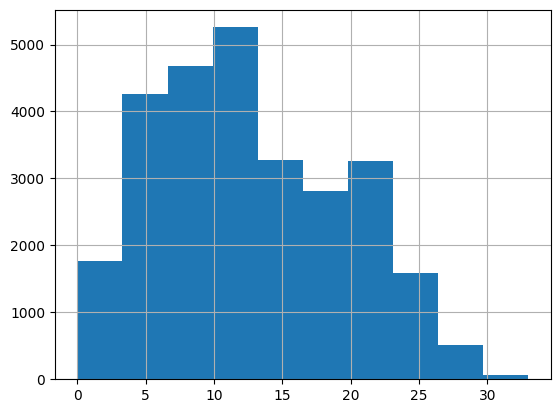

In [6]:
train_df['text_clean'].str.split().map(len).hist()

Número de palabras únicas (vocabulario) que el tokenizer ha aprendido al ajustarse al texto:

In [7]:
len(tokenizer.word_index)

31452

# **FASE 2**

In [8]:
# Lista de palabras a analizar
palabras = [w for w in tokenizer.word_counts if len(w) >= 2 and w not in stop_words]

# Procesamos todas las palabras de una vez (más eficiente)
docs = list(nlp.pipe(palabras, batch_size=1000))

# Filtramos por NOUN o PROPN
filtradas = {
    w: tokenizer.word_counts[w]
    for w, doc in zip(palabras, docs)
    if any(token.pos_ in {"NOUN", "PROPN"} for token in doc)
}

# Top 10
top_10 = sorted(filtradas.items(), key=lambda x: x[1], reverse=True)[:10]
print("Top 10 nombres con significado:")
for i, (w, f) in enumerate(top_10, 1):
    print(f"{i}. {w:<15} → {f} apariciones")


Top 10 nombres con significado:
1. day             → 2269 apariciones
2. love            → 1281 apariciones
3. today           → 1218 apariciones
4. lol             → 1062 apariciones
5. time            → 1056 apariciones
6. night           → 834 apariciones
7. home            → 800 apariciones
8. mothers         → 798 apariciones
9. thanks          → 745 apariciones
10. hope            → 660 apariciones


In [9]:
# 5) Secuencias
train_sequences = tokenizer.texts_to_sequences(train_corpus)
test_sequences  = tokenizer.texts_to_sequences(test_corpus)
all_sequences        = train_sequences + test_sequences

In [10]:
from tensorflow.keras.preprocessing.sequence import skipgrams

# Paso 3: Generación de pares con ventanas 2 y 4
pairs_dict = {
    'window_2': [],
    'window_4': []
}

for seq in all_sequences:
    # Ventana 2
    sg_pairs_2, labels_2 = skipgrams(seq, vocab_size, window_size=2, negative_samples=0)
    # Generar pares con etiquetas y añadir a pairs_dict
    pairs_dict['window_2'].extend(zip(sg_pairs_2, labels_2))

    # Ventana 4
    sg_pairs_4, labels_4 = skipgrams(seq, vocab_size, window_size=4, negative_samples=0)
    # Generar pares con etiquetas y añadir a pairs_dict
    pairs_dict['window_4'].extend(zip(sg_pairs_4, labels_4))


In [11]:
from tensorflow.keras.optimizers import Adam
# Hiperparámetros y estructuras
embedding_sizes  = [45,312,752]
window_sizes     = ['window_2','window_4']
loss_histories   = {}
final_embeddings = {}
models           = {}

for emb_size in embedding_sizes:
    for window in window_sizes:
        current_pairs = pairs_dict[window]
        if not current_pairs:
            continue

        # Separar pares y etiquetas
        pairs, labels = zip(*current_pairs)

        # Separar targets y contexts de los pares
        targets, contexts = zip(*pairs)

        # Convertir a arrays
        targets  = np.array(targets, dtype='int32')
        contexts = np.array(contexts, dtype='int32')
        y_train  = np.array(labels, dtype='float32')

        # ENTRADAS como índices, no one-hot
        target_input = Input(shape=(), dtype='int32', name='target_input')
        context_input= Input(shape=(), dtype='int32', name='context_input')

        # Capa de embeddings compartida
        embedding_layer = Embedding(
            input_dim=vocab_size,
            output_dim=emb_size,
            name=f"embedding_{emb_size}_{window}"
        )

        # Vectores de palabras
        target_vector  = embedding_layer(target_input)
        context_vector = embedding_layer(context_input)

        # Producto punto
        dot_product = Dot(axes=-1)([target_vector, context_vector])
        dot_product = Reshape((1,))(dot_product)

        # Clasificador binario
        output = Dense(1, activation='sigmoid')(dot_product)



        # Construir modelo
        model = Model(inputs=[target_input, context_input], outputs=output)
        model.compile(
            loss='binary_crossentropy',
            optimizer=Adam(0.02),
            metrics=['accuracy']
        )

        # Guardar y entrenar
        key = f'emb_{emb_size}_{window}'
        print(f"\nEntrenando modelo: {key} (Embedding size: {emb_size}, Window: {window})\n")
        models[key] = model
        history = model.fit(
            [targets, contexts],
            y_train,
            epochs=3,
            batch_size=256,
            verbose=1
        )

        loss_histories[key]   = history.history['loss']
        final_embeddings[key] = embedding_layer.get_weights()[0]


Entrenando modelo: emb_45_window_2 (Embedding size: 45, Window: window_2)

Epoch 1/3
5417/5417 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - accuracy: 0.9988 - loss: 0.0536
Epoch 2/3
5417/5417 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 1.0000 - loss: 1.1446e-04
Epoch 3/3
5417/5417 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 1.0000 - loss: 7.1572e-06

Entrenando modelo: emb_45_window_4 (Embedding size: 45, Window: window_4)

Epoch 1/3
9895/9895 ━━━━━━━━━━━━━━━━━━━━ 25s 2ms/step - accuracy: 0.9992 - loss: 0.0343
Epoch 2/3
9895/9895 ━━━━━━━━━━━━━━━━━━━━ 40s 2ms/step - accuracy: 1.0000 - loss: 8.7900e-06
Epoch 3/3
9895/9895 ━━━━━━━━━━━━━━━━━━━━ 40s 2ms/step - accuracy: 1.0000 - loss: 6.3673e-08

Entrenando modelo: emb_312_window_2 (Embedding size: 312, Window: window_2)

Epoch 1/3
5417/5417 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step - accuracy: 0.9990 - loss: 0.0127
Epoch 2/3
5417/5417 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 1.0000 - loss: 1.5150e-07
Epoch 3/3
5417/5417 ━━━━━━━━━━━━━━━━━━━━ 13s 2

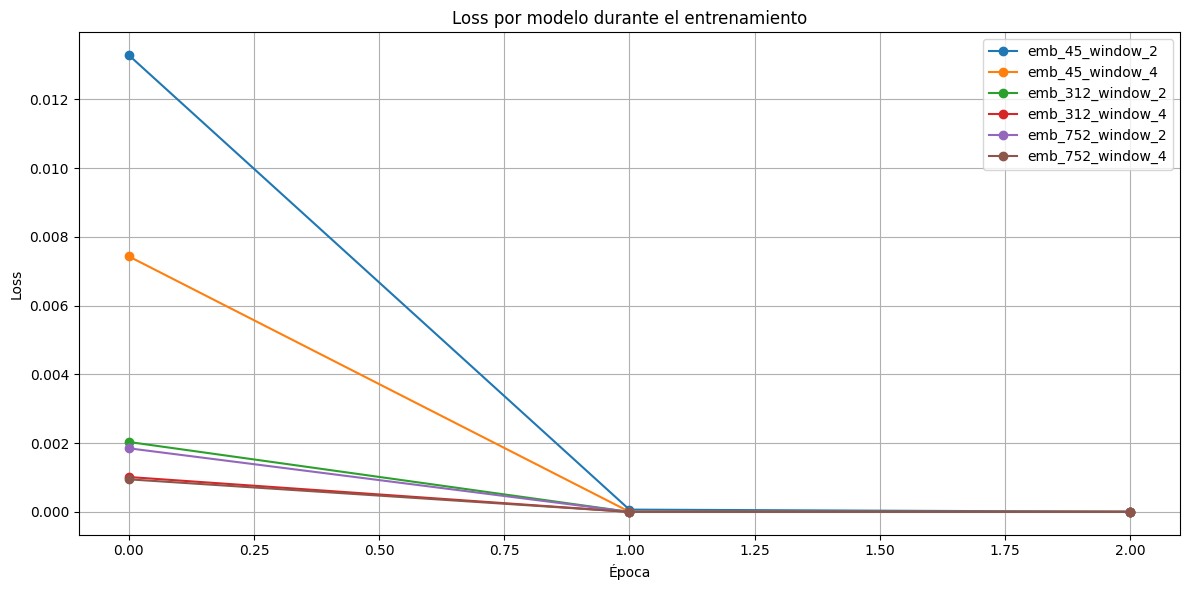

In [13]:
plt.figure(figsize=(12, 6))

for key, loss in loss_histories.items():
    plt.plot(loss, marker='o',label=key)

plt.title('Loss por modelo durante el entrenamiento')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [14]:
# Recorre cada modelo en el diccionario y muestra su summary
for key, mdl in models.items():
    print(f"\n=== Summary de {key} ===")
    mdl.summary()



=== Summary de emb_45_window_2 ===


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ target_input        │ (None)            │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ context_input       │ (None)            │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_45_windo… │ (None, 45)        │    135,045 │ target_input[0][… │
│ (Embedding)         │                   │            │ context_input[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dot (Dot)           │ (None, 1)         │          0 │ embedding_45_win… │
│                     │                   │            │ embedding_45_win… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 1)         │          0 │ dot[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 1)         │          2 │ reshape[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 405,143 (1.55 MB)

 Trainable params: 135,047 (527.53 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 270,096 (1.03 MB)


=== Summary de emb_45_window_4 ===


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ target_input        │ (None)            │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ context_input       │ (None)            │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_45_windo… │ (None, 45)        │    135,045 │ target_input[0][… │
│ (Embedding)         │                   │            │ context_input[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dot_1 (Dot)         │ (None, 1)         │          0 │ embedding_45_win… │
│                     │                   │            │ embedding_45_win… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_1 (Reshape) │ (None, 1)         │          0 │ dot_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1)         │          2 │ reshape_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 405,143 (1.55 MB)

 Trainable params: 135,047 (527.53 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 270,096 (1.03 MB)


=== Summary de emb_312_window_2 ===


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ target_input        │ (None)            │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ context_input       │ (None)            │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_312_wind… │ (None, 312)       │    936,312 │ target_input[0][… │
│ (Embedding)         │                   │            │ context_input[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dot_2 (Dot)         │ (None, 1)         │          0 │ embedding_312_wi… │
│                     │                   │            │ embedding_312_wi… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_2 (Reshape) │ (None, 1)         │          0 │ dot_2[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 1)         │          2 │ reshape_2[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,808,944 (10.72 MB)

 Trainable params: 936,314 (3.57 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,872,630 (7.14 MB)


=== Summary de emb_312_window_4 ===


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ target_input        │ (None)            │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ context_input       │ (None)            │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_312_wind… │ (None, 312)       │    936,312 │ target_input[0][… │
│ (Embedding)         │                   │            │ context_input[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dot_3 (Dot)         │ (None, 1)         │          0 │ embedding_312_wi… │
│                     │                   │            │ embedding_312_wi… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_3 (Reshape) │ (None, 1)         │          0 │ dot_3[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 1)         │          2 │ reshape_3[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,808,944 (10.72 MB)

 Trainable params: 936,314 (3.57 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,872,630 (7.14 MB)


=== Summary de emb_752_window_2 ===


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ target_input        │ (None)            │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ context_input       │ (None)            │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_752_wind… │ (None, 752)       │  2,256,752 │ target_input[0][… │
│ (Embedding)         │                   │            │ context_input[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dot_4 (Dot)         │ (None, 1)         │          0 │ embedding_752_wi… │
│                     │                   │            │ embedding_752_wi… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_4 (Reshape) │ (None, 1)         │          0 │ dot_4[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 1)         │          2 │ reshape_4[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 6,770,264 (25.83 MB)

 Trainable params: 2,256,754 (8.61 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 4,513,510 (17.22 MB)


=== Summary de emb_752_window_4 ===


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ target_input        │ (None)            │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ context_input       │ (None)            │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_752_wind… │ (None, 752)       │  2,256,752 │ target_input[0][… │
│ (Embedding)         │                   │            │ context_input[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dot_5 (Dot)         │ (None, 1)         │          0 │ embedding_752_wi… │
│                     │                   │            │ embedding_752_wi… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_5 (Reshape) │ (None, 1)         │          0 │ dot_5[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 1)         │          2 │ reshape_5[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 6,770,264 (25.83 MB)

 Trainable params: 2,256,754 (8.61 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 4,513,510 (17.22 MB)

In [15]:
# Example: vector for "love"
idx = word2idx["love"]

print(f"Embedding for 'love':\n{final_embeddings['emb_45_window_2'][idx]}")

Embedding for 'love':
[-0.12441203 -0.14520453  0.33836496  0.40074852 -0.04428394  0.04702107
 -0.00057139 -0.06111796 -0.28830984  0.00962042  0.03372611  0.01741217
 -0.05532506  0.35622275  0.34137145  0.04795158  0.00842591  0.1815484
  0.1883982  -0.3335617  -0.2203817   0.12340423 -0.18772747 -0.1896925
 -0.24999554  0.1553059   0.24027392 -0.06628372  0.16616349  0.53505903
  0.08233912  0.16835642  0.21322395  0.20701103 -0.17771222  0.34857795
  0.3116786  -0.15403214 -0.09296052 -0.21269046 -0.13729735  0.05850873
 -0.4625448  -0.12256546 -0.00594413]


In [16]:

# 1) Lista de las 10 palabras puras (sin frecuencia)
top_10_words = [w for w,_ in top_10]

# 2) Extrae los índices solo de las que realmente estén en tu vocabulario
indices = []
words   = []
for w in top_10_words:
    if w in word2idx:
        indices.append(word2idx[w])
        words.append(w)
    else:
        print(f"Advertencia: '{w}' no está en el vocabulario")

# 3) Recorre cada modelo en final_embeddings
for model_key, emb_matrix in final_embeddings.items():
    # 4) Submatriz de solo las top palabras
    submat = emb_matrix[indices]            # (n_words, emb_dim)

    # 5) Calcula similitud de coseno
    sim_mat = cosine_similarity(submat)     # (n_words, n_words)

    # 6) Construye DataFrame y muestra
    print(f"\n— Similitud de coseno para {model_key} —")
    df_sim = pd.DataFrame(sim_mat, index=words, columns=words)
    display(df_sim)




— Similitud de coseno para emb_45_window_2 —


,day,love,today,lol,time,night,home,mothers,thanks,hope
day,1.000000,-0.150079,-0.174724,-0.040226,0.478486,0.448546,0.035276,-0.448038,0.120680,-0.103965
love,-0.150079,1.000000,0.094322,0.002384,-0.148553,-0.022620,-0.181411,0.123066,0.109742,0.305734
today,-0.174724,0.094322,1.000000,0.103407,-0.184759,-0.052768,-0.144129,0.167959,0.132049,-0.270810
lol,-0.040226,0.002384,0.103407,1.000000,0.059853,-0.033091,-0.098672,-0.194384,-0.137880,-0.027066
time,0.478486,-0.148553,-0.184759,0.059853,1.000000,0.346492,-0.104863,-0.038199,0.345763,-0.056529
night,0.448546,-0.022620,-0.052768,-0.033091,0.346492,1.000000,0.016097,0.016187,0.197585,-0.102157
home,0.035276,-0.181411,-0.144129,-0.098672,-0.104863,0.016097,1.000000,-0.308132,-0.087385,-0.157099
mothers,-0.448038,0.123066,0.167959,-0.194384,-0.038199,0.016187,-0.308132,1.000000,0.028754,-0.042212
thanks,0.120680,0.109742,0.132049,-0.137880,0.345763,0.197585,-0.087385,0.028754,1.000000,0.097789
hope,-0.103965,0.305734,-0.270810,-0.027066,-0.056529,-0.102157,-0.157099,-0.042212,0.097789,1.000000



— Similitud de coseno para emb_45_window_4 —


,day,love,today,lol,time,night,home,mothers,thanks,hope
day,1.000000,-0.108085,-0.065388,-0.008275,0.418227,0.444749,-0.332631,-0.443802,0.061869,0.219689
love,-0.108085,1.000000,-0.071603,0.078621,-0.132020,0.017740,-0.197446,0.121014,0.023329,0.367301
today,-0.065388,-0.071603,1.000000,0.122438,-0.136553,0.185587,0.008635,-0.000728,-0.200300,-0.000874
lol,-0.008275,0.078621,0.122438,1.000000,0.159009,0.067260,-0.090726,0.021118,-0.208547,0.231147
time,0.418227,-0.132020,-0.136553,0.159009,1.000000,0.223136,-0.191910,0.063287,0.335604,0.147752
night,0.444749,0.017740,0.185587,0.067260,0.223136,1.000000,-0.287379,0.052105,0.048436,0.080147
home,-0.332631,-0.197446,0.008635,-0.090726,-0.191910,-0.287379,1.000000,0.043538,0.105181,-0.062920
mothers,-0.443802,0.121014,-0.000728,0.021118,0.063287,0.052105,0.043538,1.000000,0.140503,-0.146212
thanks,0.061869,0.023329,-0.200300,-0.208547,0.335604,0.048436,0.105181,0.140503,1.000000,0.014149
hope,0.219689,0.367301,-0.000874,0.231147,0.147752,0.080147,-0.062920,-0.146212,0.014149,1.000000



— Similitud de coseno para emb_312_window_2 —


,day,love,today,lol,time,night,home,mothers,thanks,hope
day,1.000000,0.794824,0.797260,0.768479,0.770619,0.707442,0.796901,0.923165,0.661525,0.732404
love,0.794824,1.000000,0.846540,0.784590,0.805944,0.764265,0.869589,0.790154,0.686649,0.847582
today,0.797260,0.846540,1.000000,0.871791,0.828509,0.751196,0.875714,0.774220,0.712210,0.844206
lol,0.768479,0.784590,0.871791,1.000000,0.794391,0.750850,0.835698,0.734710,0.717264,0.841663
time,0.770619,0.805944,0.828509,0.794391,1.000000,0.692497,0.857816,0.772389,0.674109,0.803065
night,0.707442,0.764265,0.751196,0.750850,0.692497,1.000000,0.760840,0.656199,0.663456,0.780704
home,0.796901,0.869589,0.875714,0.835698,0.857816,0.760840,1.000000,0.786147,0.711495,0.878581
mothers,0.923165,0.790154,0.774220,0.734710,0.772389,0.656199,0.786147,1.000000,0.640579,0.721318
thanks,0.661525,0.686649,0.712210,0.717264,0.674109,0.663456,0.711495,0.640579,1.000000,0.713009
hope,0.732404,0.847582,0.844206,0.841663,0.803065,0.780704,0.878581,0.721318,0.713009,1.000000



— Similitud de coseno para emb_312_window_4 —


,day,love,today,lol,time,night,home,mothers,thanks,hope
day,1.000000,0.669953,0.595366,0.630264,0.731018,0.724990,0.706492,0.869490,0.696172,0.714463
love,0.669953,1.000000,0.565291,0.672324,0.721146,0.690442,0.705795,0.674978,0.735945,0.731000
today,0.595366,0.565291,1.000000,0.652178,0.662496,0.612973,0.615400,0.630455,0.651999,0.613090
lol,0.630264,0.672324,0.652178,1.000000,0.723055,0.710359,0.649051,0.651910,0.631051,0.710693
time,0.731018,0.721146,0.662496,0.723055,1.000000,0.742814,0.731816,0.742540,0.712345,0.801062
night,0.724990,0.690442,0.612973,0.710359,0.742814,1.000000,0.704400,0.730508,0.666899,0.714855
home,0.706492,0.705795,0.615400,0.649051,0.731816,0.704400,1.000000,0.718009,0.699805,0.757823
mothers,0.869490,0.674978,0.630455,0.651910,0.742540,0.730508,0.718009,1.000000,0.682362,0.745084
thanks,0.696172,0.735945,0.651999,0.631051,0.712345,0.666899,0.699805,0.682362,1.000000,0.690518
hope,0.714463,0.731000,0.613090,0.710693,0.801062,0.714855,0.757823,0.745084,0.690518,1.000000



— Similitud de coseno para emb_752_window_2 —


,day,love,today,lol,time,night,home,mothers,thanks,hope
day,1.000000,0.471412,0.715183,0.579203,0.646429,0.547702,0.608189,0.810646,0.512648,0.530654
love,0.471412,1.000000,0.584440,0.626461,0.617922,0.544550,0.612194,0.401122,0.529690,0.621211
today,0.715183,0.584440,1.000000,0.727379,0.762912,0.648004,0.729071,0.673187,0.659509,0.671071
lol,0.579203,0.626461,0.727379,1.000000,0.724668,0.626436,0.734955,0.511421,0.640139,0.688416
time,0.646429,0.617922,0.762912,0.724668,1.000000,0.659430,0.740889,0.581024,0.646928,0.697472
night,0.547702,0.544550,0.648004,0.626436,0.659430,1.000000,0.606403,0.494358,0.560506,0.574262
home,0.608189,0.612194,0.729071,0.734955,0.740889,0.606403,1.000000,0.529166,0.664329,0.674714
mothers,0.810646,0.401122,0.673187,0.511421,0.581024,0.494358,0.529166,1.000000,0.454020,0.468291
thanks,0.512648,0.529690,0.659509,0.640139,0.646928,0.560506,0.664329,0.454020,1.000000,0.593439
hope,0.530654,0.621211,0.671071,0.688416,0.697472,0.574262,0.674714,0.468291,0.593439,1.000000



— Similitud de coseno para emb_752_window_4 —


,day,love,today,lol,time,night,home,mothers,thanks,hope
day,1.000000,0.522509,0.548390,0.509875,0.527366,0.436767,0.506693,0.739037,0.526477,0.584359
love,0.522509,1.000000,0.502011,0.534408,0.550023,0.468060,0.551956,0.475662,0.520019,0.471390
today,0.548390,0.502011,1.000000,0.453564,0.603798,0.544507,0.539090,0.532291,0.556518,0.449704
lol,0.509875,0.534408,0.453564,1.000000,0.478687,0.443746,0.504192,0.487394,0.518327,0.436720
time,0.527366,0.550023,0.603798,0.478687,1.000000,0.499735,0.539076,0.489687,0.596811,0.521568
night,0.436767,0.468060,0.544507,0.443746,0.499735,1.000000,0.522130,0.409119,0.472868,0.408889
home,0.506693,0.551956,0.539090,0.504192,0.539076,0.522130,1.000000,0.475925,0.567051,0.417061
mothers,0.739037,0.475662,0.532291,0.487394,0.489687,0.409119,0.475925,1.000000,0.501030,0.472151
thanks,0.526477,0.520019,0.556518,0.518327,0.596811,0.472868,0.567051,0.501030,1.000000,0.444976
hope,0.584359,0.471390,0.449704,0.436720,0.521568,0.408889,0.417061,0.472151,0.444976,1.000000


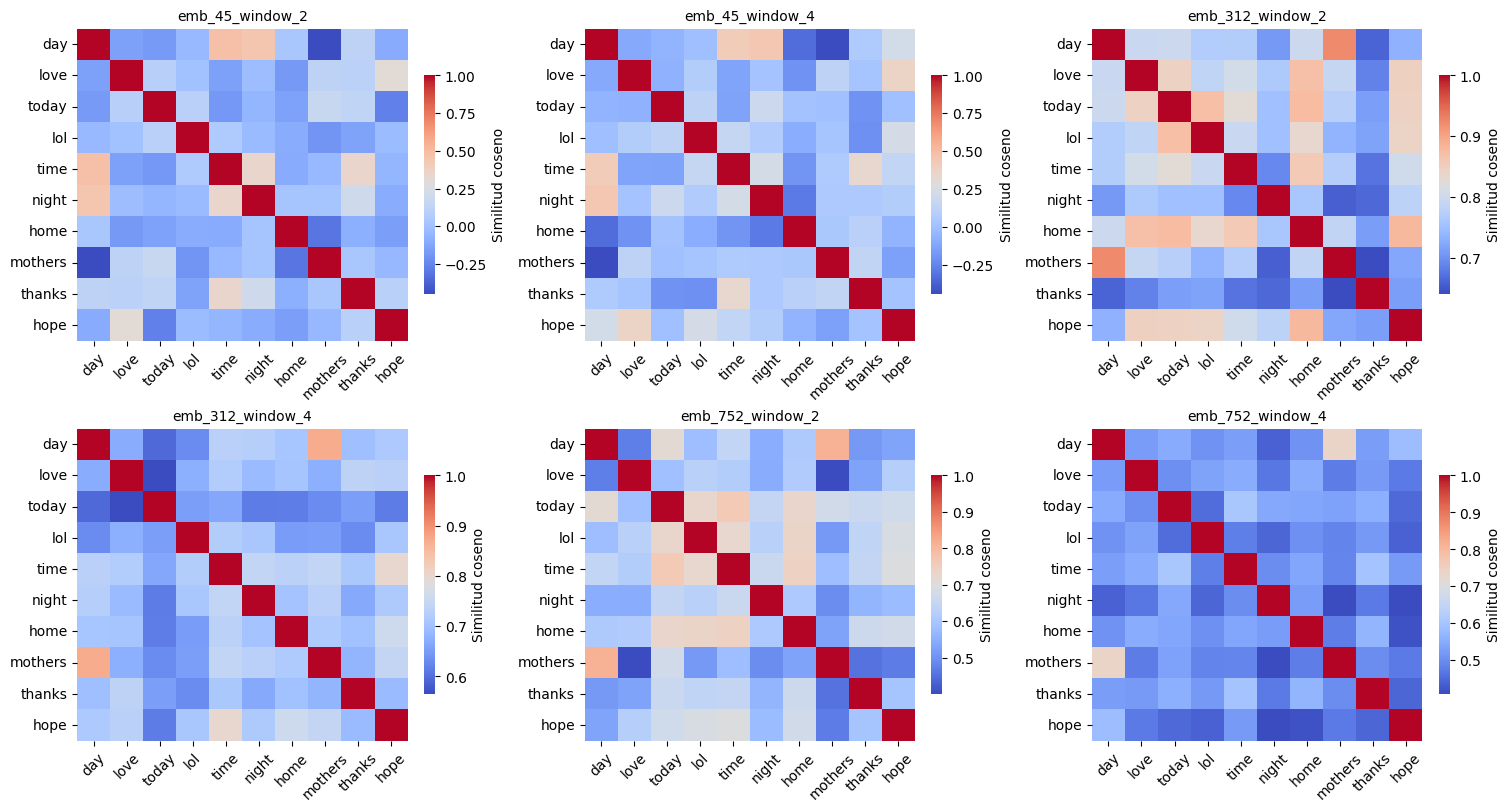

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity

# 1) Lista de las 10 palabras puras (sin frecuencia)
top_10_words = [w for w, _ in top_10]

# 2) Extrae los índices solo de las que estén en el vocabulario
indices = []
words = []
for w in top_10_words:
    if w in word2idx:
        indices.append(word2idx[w])
        words.append(w)
    else:
        print(f"Advertencia: '{w}' no está en el vocabulario")

# 3) Cantidad de modelos a graficar
n_models = len(final_embeddings)
cols = 3
rows = (n_models + cols - 1) // cols

# 4) Crear figura con constrained_layout
fig, axs = plt.subplots(rows, cols, figsize=(cols * 5, rows * 4), constrained_layout=True)
axs = axs.flatten()

# 5) Recorremos los embeddings
for i, (model_key, emb_matrix) in enumerate(final_embeddings.items()):
    submat = emb_matrix[indices]
    sim_mat = cosine_similarity(submat)
    df_sim = pd.DataFrame(sim_mat, index=words, columns=words)

    sns.heatmap(
        df_sim,
        ax=axs[i],
        cmap="coolwarm",
        annot=False,
        cbar=True,
        cbar_kws={'shrink': 0.7, 'label': 'Similitud coseno'}
    )
    axs[i].set_title(model_key, fontsize=10)
    axs[i].tick_params(axis='x', rotation=45)
    axs[i].tick_params(axis='y', rotation=0)

# 6) Eliminar ejes vacíos
for j in range(i + 1, len(axs)):
    fig.delaxes(axs[j])

plt.show()


In [22]:


# Define aquí tres grupos basados en tu top-10
grupos = {
    'Día/Mañana':     ['day', 'today', 'morning'],
    'Emoción Positiva':['love', 'hope', 'thanks'],
    'Risa/Conversación':['lol', 'thanks', 'mothers']  # ejemplo mixto
}

for model_key, emb_matrix in final_embeddings.items():
    print(f"\n=== Similitudes para {model_key} ===")
    # Extrae solo los vectores de tus 10 palabras
    submat = emb_matrix[indices]           # (10, emb_dim)
    sim_mat = cosine_similarity(submat)    # (10, 10)

    # Mapea palabra -> posición en 'words'
    pos = {w:i for i,w in enumerate(words)}

    for nombre, group in grupos.items():
        # Filtra solo los que realmente están en tu top
        valid = [w for w in group if w in pos]
        idxs  = [pos[w] for w in valid]
        if len(idxs) < 2:
            print(f"  * Grupo «{nombre}» tiene <2 palabras válidas, omito.")
            continue

        sims = []
        print(f"\n  Grupo «{nombre}»: {valid}")
        for i,j in combinations(idxs, 2):
            s = sim_mat[i, j]
            sims.append(s)
            print(f"    Sim({words[i]}, {words[j]}) = {s:.3f}")

        print(f"    → Similitud media = {np.mean(sims):.3f}")




=== Similitudes para emb_45_window_2 ===

  Grupo «Día/Mañana»: ['day', 'today']
    Sim(day, today) = -0.175
    → Similitud media = -0.175

  Grupo «Emoción Positiva»: ['love', 'hope', 'thanks']
    Sim(love, hope) = 0.306
    Sim(love, thanks) = 0.110
    Sim(hope, thanks) = 0.098
    → Similitud media = 0.171

  Grupo «Risa/Conversación»: ['lol', 'thanks', 'mothers']
    Sim(lol, thanks) = -0.138
    Sim(lol, mothers) = -0.194
    Sim(thanks, mothers) = 0.029
    → Similitud media = -0.101

=== Similitudes para emb_45_window_4 ===

  Grupo «Día/Mañana»: ['day', 'today']
    Sim(day, today) = -0.065
    → Similitud media = -0.065

  Grupo «Emoción Positiva»: ['love', 'hope', 'thanks']
    Sim(love, hope) = 0.367
    Sim(love, thanks) = 0.023
    Sim(hope, thanks) = 0.014
    → Similitud media = 0.135

  Grupo «Risa/Conversación»: ['lol', 'thanks', 'mothers']
    Sim(lol, thanks) = -0.209
    Sim(lol, mothers) = 0.021
    Sim(thanks, mothers) = 0.141
    → Similitud media = -0.016



# **FASE 3**

In [28]:
# 1) Carga y limpieza
train_df['text_clean'] = train_df['text'].apply(limpiar_texto)
test_df ['text_clean'] = test_df ['text'].apply(limpiar_texto)

In [92]:
# --- FASE 3: DOS RNN SECUENCIALES CON EMBEDDINGS PRE-ENTRENADOS ---

# Parámetros generales
maxlen        = 30
batch_rnn     = 128
epochs_rnn    = 5
learning_rate = 0.005

# 1) Usa SMALL_TRAIN_DF / SMALL_TEST_DF y quita filas sin etiqueta
train_df.dropna(subset=['sentiment'], inplace=True)
test_df.dropna(subset=['sentiment'], inplace=True)

texts_train = train_df['text_clean'].tolist()
texts_test  = test_df['text_clean'].tolist()

# 2) LabelEncoder para convertir strings → enteros
le       = LabelEncoder()
y_train  = le.fit_transform(train_df['sentiment'])
y_test   = le.transform(test_df['sentiment'])
y_train  = y_train.astype('int32')
y_test   = y_test.astype('int32')
num_classes = len(le.classes_)
print("Clases sentiment codificadas:", le.classes_)

# 3) Secuencias + padding
seq_train = tokenizer.texts_to_sequences(texts_train)
seq_test  = tokenizer.texts_to_sequences(texts_test)
X_train   = pad_sequences(seq_train, maxlen=maxlen, padding='post')
X_test    = pad_sequences(seq_test,  maxlen=maxlen, padding='post')

# 4) Crea datasets optimizados
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)) \
                         .shuffle(len(X_train)) \
                         .batch(batch_rnn) \
                         .prefetch(tf.data.AUTOTUNE)
test_ds  = tf.data.Dataset.from_tensor_slices((X_test, y_test)) \
                         .batch(batch_rnn) \
                         .prefetch(tf.data.AUTOTUNE)

# 5) Elige qué embeddings usar
key_A = 'emb_45_window_2'
key_B = 'emb_45_window_4'
emb_A = final_embeddings[key_A]
emb_B = final_embeddings[key_B]
vocab_sz = vocab_size



Clases sentiment codificadas: ['negative' 'neutral' 'positive']


In [93]:
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Dropout

# --- Modelo A con regularización y dropout ---
model_A = keras.Sequential([
    Embedding(input_dim=vocab_sz,
              output_dim=emb_A.shape[1],
              weights=[emb_A],
              trainable=True),
    Bidirectional(LSTM(64, return_sequences=True)),
    Dropout(0.4),
    Bidirectional(GRU(64)),
    Dropout(0.4),
    Dense(64, activation='relu',
          kernel_regularizer=regularizers.l2(1e-4)),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
], name='Model_A')

model_A.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
    metrics=['accuracy']
)
model_A.summary()
# --- Modelo B con regularización y dropout ---
model_B = keras.Sequential([
    Embedding(input_dim=vocab_sz,
              output_dim=emb_B.shape[1],
              weights=[emb_B],
              trainable=True),
    Bidirectional(LSTM(32)),
    Dropout(0.5),
    Dense(64, activation='relu',
          kernel_regularizer=regularizers.l2(1e-4)),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
], name='Model_B')

model_B.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
    metrics=['accuracy']
)
model_B.summary()

Model: "Model_A"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_28 (Embedding)        │ ?                      │       135,045 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_42                │ ?                      │   0 (unbuilt) │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_70 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_43                │ ?                      │   0 (unbuilt) │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_71 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_62 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_72 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_63 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 135,045 (527.52 KB)

 Trainable params: 135,045 (527.52 KB)

 Non-trainable params: 0 (0.00 B)

Model: "Model_B"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_29 (Embedding)        │ ?                      │       135,045 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_44                │ ?                      │   0 (unbuilt) │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_73 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_64 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_74 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_65 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 135,045 (527.52 KB)

 Trainable params: 135,045 (527.52 KB)

 Non-trainable params: 0 (0.00 B)

In [90]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = dict(enumerate(class_weights))

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',     # monitor validation loss
    factor=0.5,             # reduce by half
    patience=1,             # after 1 epoch with no improvement
    min_lr=1e-5,            # don't go below this
    verbose=1
)

In [94]:
## nota: PARA EJECUTAR DE NUEVO, ANTES EJECUTAR LA DEFINICIÓN DE LOS MODELOS PARA QUE EMPIECEN DE CERO
# 8) Entrena ambos
print("\n>>> Entrenando Model A")
history_A = model_A.fit(
    train_ds,
    validation_data=test_ds,
    epochs=epochs_rnn,
    class_weight=class_weights,
    callbacks=[reduce_lr]
)

print("\n>>> Entrenando Model B")
history_B = model_B.fit(
    train_ds,
    validation_data=test_ds,
    epochs=epochs_rnn,
    class_weight=class_weights,
    callbacks=[reduce_lr]
)




>>> Entrenando Model A
Epoch 1/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - accuracy: 0.4902 - loss: 0.9794 - val_accuracy: 0.7068 - val_loss: 0.6895 - learning_rate: 0.0050
Epoch 2/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - accuracy: 0.7325 - loss: 0.6448 - val_accuracy: 0.7295 - val_loss: 0.6455 - learning_rate: 0.0050
Epoch 3/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.7592 - loss: 0.5896 - val_accuracy: 0.7301 - val_loss: 0.6390 - learning_rate: 0.0050
Epoch 4/5
212/215 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7873 - loss: 0.5302
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0024999999441206455.
215/215 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.7871 - loss: 0.5305 - val_accuracy: 0.7255 - val_loss: 0.6601 - learning_rate: 0.0050
Epoch 5/5
214/215 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8063 - loss: 0.4766
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.
215/215 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 

## MODELO A

In [95]:
import numpy as np

# Get predicted class probabilities
y_probs = model_A.predict(X_test)

# Get predicted class labels (highest probability)
y_pred = np.argmax(y_probs, axis=1)


111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


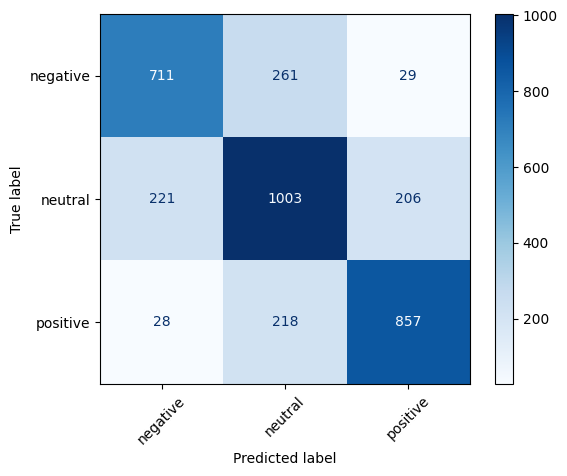

In [96]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display it nicely
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(cmap='Blues', xticks_rotation=45)


## MODELO B

In [97]:
import numpy as np

# Get predicted class probabilities
y_probs = model_B.predict(X_test)

# Get predicted class labels (highest probability)
y_pred = np.argmax(y_probs, axis=1)

111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


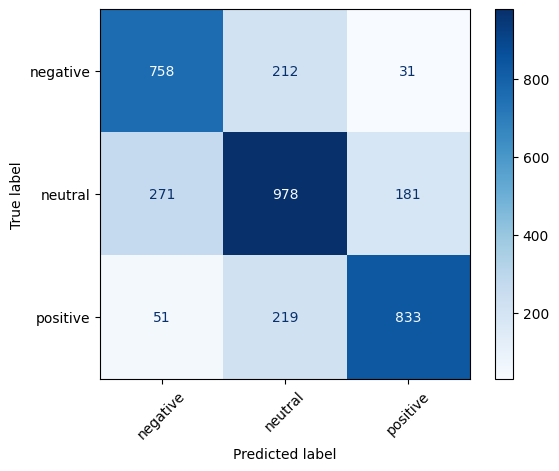

In [98]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display it nicely
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(cmap='Blues', xticks_rotation=45)


=== Evaluación en TEST ===

--- Model A ---
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

Classification Report:
              precision    recall  f1-score   support

    negative       0.74      0.71      0.73      1001
     neutral       0.68      0.70      0.69      1430
    positive       0.78      0.78      0.78      1103

    accuracy                           0.73      3534
   macro avg       0.73      0.73      0.73      3534
weighted avg       0.73      0.73      0.73      3534


--- Model B ---
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

Classification Report:
              precision    recall  f1-score   support

    negative       0.70      0.76      0.73      1001
     neutral       0.69      0.68      0.69      1430
    positive       0.80      0.76      0.78      1103

    accuracy                           0.73      3534
   macro avg       0.73      0.73      0.73      3534
weighted avg       0.73      0.73      0.73      3534



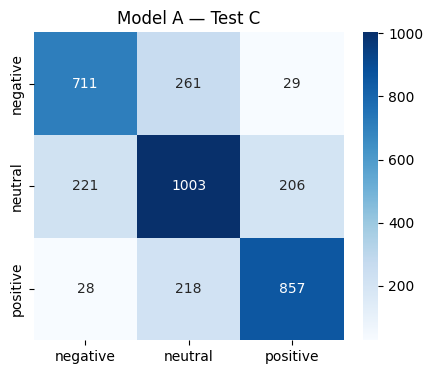

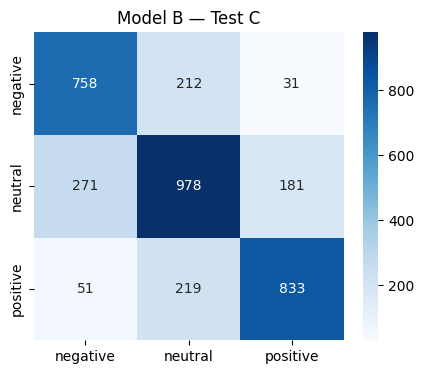

In [99]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

print("\n=== Evaluación en TEST ===")
for name, model in [('Model A', model_A), ('Model B', model_B)]:
    print(f"\n--- {name} ---")

    # Predicción en test
    y_test_probs = model.predict(X_test)
    y_test_pred = np.argmax(y_test_probs, axis=1)

    # Matriz de confusión
    cm_test = confusion_matrix(y_test, y_test_pred)

    # Métricas detalladas
    print("\nClassification Report:")
    print(classification_report(y_test, y_test_pred, target_names=le.classes_))

    # Gráfico
    plt.figure(figsize=(5,4))
    sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
    plt.title(f'{name} — Test C')


In [100]:
# List of sample indices to test
sample_indices = [0,1,2]

# Loop through each sample
for idx in sample_indices:
    # 1) Saca una frase de prueba
    sample_text = test_df['text_clean'].iloc[idx]
    print(f"\n-----\nSample text: {sample_text}")

    # 2) Tokeniza y paddea la frase
    sample_seq = tokenizer.texts_to_sequences([sample_text])
    sample_pad = pad_sequences(sample_seq, maxlen=maxlen, padding='post')

    # 3) MODELO A
    print("=================Utilizando el modelo A=================")
    model = model_A  # o model_B

    # 4) Predicción
    pred_probs = model.predict(sample_pad)
    pred_label = np.argmax(pred_probs, axis=1)[0]
    pred_class = le.inverse_transform([pred_label])[0]

    # Imprimir el resultado con las probabilidades de cada clase
    print(f"\nPredicted sentiment: {pred_class} with")

    # Especificar las probabilidades para cada clase (asumimos que hay 3 clases: negative, neutral, positive)
    labels = ['negative', 'neutral', 'positive']
    for i, prob in enumerate(pred_probs[0]):
        print(f"Probability of {labels[i]}: {prob:.8f}")

    # MODELO B
    print("=================Utilizando el modelo B=================")
    model = model_B

    # 4) Predicción
    pred_probs = model.predict(sample_pad)
    pred_label = np.argmax(pred_probs, axis=1)[0]
    pred_class = le.inverse_transform([pred_label])[0]

    # Imprimir el resultado con las probabilidades de cada clase
    print(f"\nPredicted sentiment: {pred_class} with")

    # Especificar las probabilidades para cada clase (asumimos que hay 3 clases: negative, neutral, positive)
    labels = ['negative', 'neutral', 'positive']
    for i, prob in enumerate(pred_probs[0]):
        print(f"Probability of {labels[i]}: {prob:.8f}")



-----
Sample text: last session of the day  httptwitpiccom67ezh
=================Utilizando el modelo A=================
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step

Predicted sentiment: neutral with
Probability of negative: 0.04801010
Probability of neutral: 0.78880000
Probability of positive: 0.16318996
=================Utilizando el modelo B=================
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step

Predicted sentiment: neutral with
Probability of negative: 0.10834970
Probability of neutral: 0.77923745
Probability of positive: 0.11241283

-----
Sample text:  shanghai is also really exciting precisely  skyscrapers galore good tweeps in china  sh  bj
=================Utilizando el modelo A=================
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step

Predicted sentiment: positive with
Probability of negative: 0.00233931
Probability of neutral: 0.03112047
Probability of positive: 0.96654016
=================Utilizando el modelo B=================
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step

Predicted sent